# Disease Prediction from Medical Data

# Import Libraries

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Data Set Read


In [70]:
df = pd.read_csv('/content/heart.csv.csv')


In [71]:
df.head(30)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


Drop

In [72]:
df = df.drop(columns=['id', 'dataset'])

Target Variable

In [73]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
y = df['num']

Categorical to String

In [74]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

In [75]:
df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

Rest of Column

In [76]:
df_encoded = pd.get_dummies(df, columns=['sex', 'cp', 'restecg', 'slope', 'thal'], drop_first=True, dtype=int)

Numerical Column

In [77]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
features = df_encoded.drop(columns=['num']).columns

X = df_encoded.drop(columns=['num'])

Encoding

Use of KNNImputer

In [78]:
from sklearn.impute import KNNImputer
import numpy as np

# Replace '?' with NaN in the original df before encoding
df = df.replace('?', np.nan)

# Re-encode the categorical features after replacing '?' with NaN
df_encoded = pd.get_dummies(df, columns=['sex', 'cp', 'restecg', 'slope', 'thal'], drop_first=True, dtype=int)


numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

imputer = KNNImputer(n_neighbors=5)


df_encoded[numerical_cols] = imputer.fit_transform(df_encoded[numerical_cols])


df_encoded['ca'] = df_encoded['ca'].round().astype(int)

X = df_encoded.drop(columns=['num'])

In [79]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_imputed['ca'] = X_imputed['ca'].apply(lambda x: 1 if x > 0 and x < 1 else round(x))

Train and Test

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

#  (Data Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  (Handling Class Imbalance) - SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

Scikit-learn Pipeline O Cross-Validation

In [81]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Data Scaling o Model ke ekta pipeline-e rakha
# SMOTE alada kora hoyechhe, karon eta shudhu training data-te apply kora uuchit

# Example for XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# K-Fold Cross-Validation Set kora
# Stratified K-Fold bebohar kora uuchit karon eta target class gulo-ke
# prottek fold-e shoman bhabe bhag kore
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-Validation Score gulo dekha
# Apni accuracy, recall, o F1-score gulo dekhte paren
# (medical problem er jonno Recall o F1-score beshi dorkari)
scores = cross_val_score(xgb_pipeline, X_train_res, y_train_res, cv=skf, scoring='recall') # X_res, y_res holo SMOTE er porer data
print(f"XGBoost Cross-Validation Recall Scores: {scores}")
print(f"XGBoost Mean Recall: {scores.mean():.4f}")

# Ekhon pipeline ke train o test kora
xgb_pipeline.fit(X_train_res, y_train_res)
y_pred = xgb_pipeline.predict(X_test)

# Result tulona kora
print("\n--- XGBoost Pipeline Final Evaluation ---")
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_pred):.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /w

XGBoost Cross-Validation Recall Scores: [0.75609756 0.80487805 0.87654321 0.87654321 0.83950617]
XGBoost Mean Recall: 0.8307

--- XGBoost Pipeline Final Evaluation ---
Test Recall: 0.3725
Test F1-Score: 0.5101


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Grid Cv

In [82]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train_res, y_train_res)
best_xgb_model = xgb_grid_search.best_estimator_

#(Evaluation)
xgb_pred = best_xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:29:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hyperparameter Tuning (GridSearchCV)

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Pipeline  (Scaling o Random Forest)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])


param_grid = {

    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='recall',
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train_res, y_train_res)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Recall Score: {grid_search.best_score_:.4f}")

# with Best estimato diye final prediction
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)


print("\n--- Tuned Random Forest Final Evaluation ---")
print(f"Test Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best Cross-Validation Recall Score: 0.8452

--- Tuned Random Forest Final Evaluation ---
Test Recall: 0.9314
Test F1-Score: 0.8520


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [84]:
from sklearn.metrics import accuracy_score

# (XGBoost)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"Test Accuracy: {xgb_accuracy:.3f}")


Test Accuracy: 0.853


In [85]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_res, y_train_res)
best_rf_model = rf_grid_search.best_estimator_

#  (Evaluation)
rf_pred = best_rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])

In [86]:
from sklearn.metrics import accuracy_score

# (RF)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Test Accuracy: {rf_accuracy:.3f}")

Test Accuracy: 0.859


In [87]:
# Logistic Regression (Standard Model)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_res, y_train_res)

#  (Evaluation)
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

In [88]:
from sklearn.metrics import accuracy_score

# (LR)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Test Accuracy: {lr_accuracy:.3f}")

Test Accuracy: 0.832


In [89]:
print("==============================================")
print("             Final Model: RF             ")
print("==============================================")
print(f"Test Accuracy: {rf_accuracy:.3f}")
print(f"AUC-ROC Score: {rf_roc_auc:.3f}")
print("\nClassification Report (rf):")
print(classification_report(y_test, rf_pred))

             Final Model: RF             
Test Accuracy: 0.859
AUC-ROC Score: 0.912

Classification Report (rf):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



Best Model

In [90]:
#  (Saving the Best Model)
joblib.dump(best_xgb_model, 'best_disease_prediction_model.pkl')

#  (Saving the Scaler)

joblib.dump(scaler, 'scaler_for_prediction.pkl')

print("Mmodel and Scaler successfully saved!")

Mmodel and Scaler successfully saved!


# Plot

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


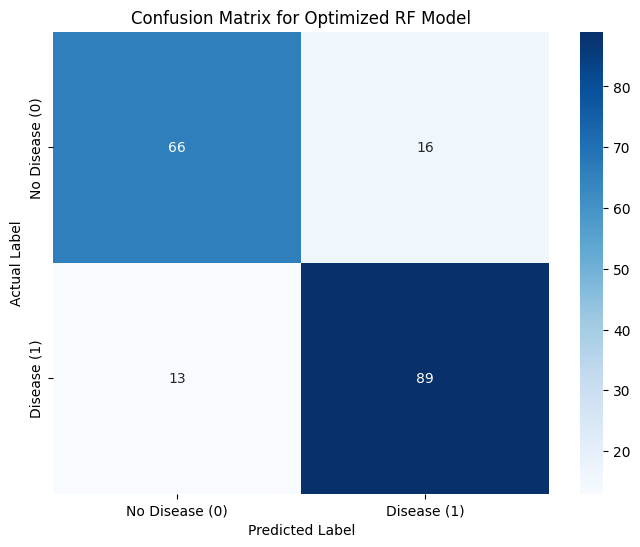

In [91]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# RF
# Use the best_rf_model which is a Pipeline object
rf_pred = best_rf_model.predict(X_test) # Predict using the pipeline

cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease (0)', 'Disease (1)'],
            yticklabels=['No Disease (0)', 'Disease (1)'])
plt.title('Confusion Matrix for Optimized RF Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

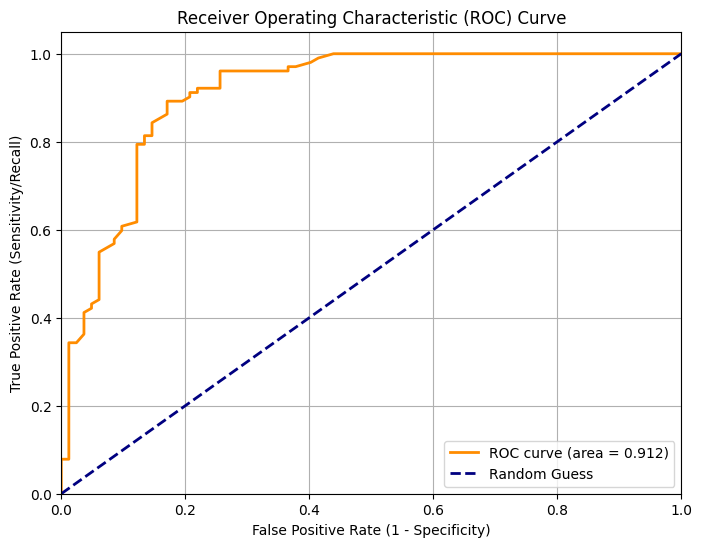

In [92]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# (Prediction Probabilities)
rf_probs = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

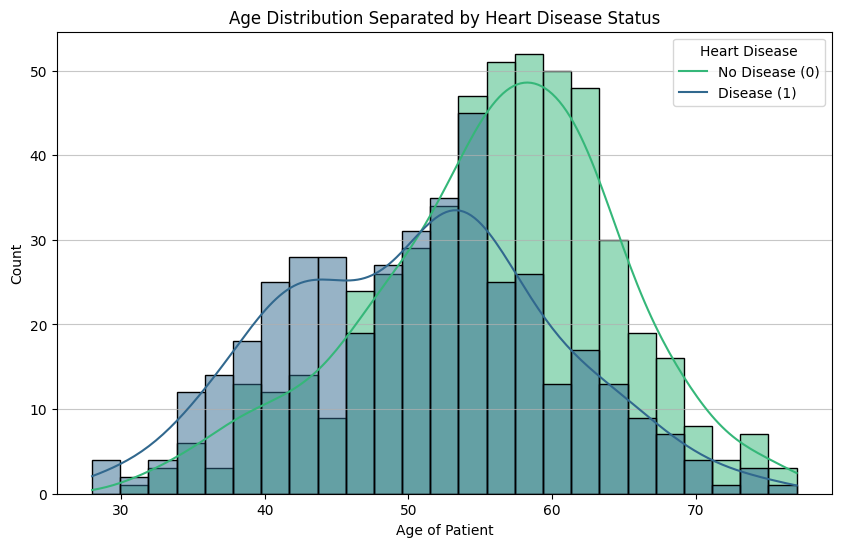

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='num', kde=True, bins=25, palette='viridis')
plt.title('Age Distribution Separated by Heart Disease Status')
plt.xlabel('Age of Patient')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease (0)', 'Disease (1)'])
plt.grid(axis='y', alpha=0.7)
plt.show()

Model & Scaler load


In [94]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import joblib

# Load trained model and scaler
best_model = joblib.load('best_disease_prediction_model.pkl')
scaler_loaded = joblib.load('scaler_for_prediction.pkl')

# Load original dataset to fit imputer for 'ca'
original_df = pd.read_csv('/content/heart.csv.csv')
original_df['num'] = original_df['num'].apply(lambda x: 1 if x > 0 else 0)
original_df = original_df.drop(columns=['id', 'dataset'])

# Convert True/False columns
original_df['fbs'] = original_df['fbs'].map({True: 1, False: 0})
original_df['exang'] = original_df['exang'].map({True: 1, False: 0})

# One-Hot Encode categorical columns
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
original_df_encoded = pd.get_dummies(original_df, columns=categorical_cols, drop_first=True, dtype=int)

# Fit SimpleImputer on 'ca'
imputer_ca = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_ca.fit(original_df_encoded[['ca']])


SimpleImputer()

Take Patient Data Console Input

In [95]:
def get_patient_input():
    """
    Collect patient info from console input
    """
    patient_data = {}

    # Numeric Inputs
    patient_data['age'] = float(input("Enter Age: "))
    patient_data['trestbps'] = float(input("Enter Resting Blood Pressure (trestbps): "))
    patient_data['chol'] = float(input("Enter Cholesterol (chol): "))
    patient_data['thalch'] = float(input("Enter Max Heart Rate (thalch): "))
    patient_data['oldpeak'] = float(input("Enter ST Depression (oldpeak): "))
    patient_data['ca'] = float(input("Enter number of major vessels colored by fluoroscopy (ca): "))

    # Binary Inputs
    fbs_input = input("Fasting Blood Sugar > 120 mg/dl? (yes/no): ").lower()
    patient_data['fbs'] = True if fbs_input in ['yes', 'y'] else False

    exang_input = input("Exercise Induced Angina? (yes/no): ").lower()
    patient_data['exang'] = True if exang_input in ['yes', 'y'] else False

    # Categorical Inputs
    patient_data['sex'] = input("Sex (Male/Female): ")
    patient_data['cp'] = input("Chest Pain Type (typical angina / atypical angina / non-anginal pain / asymptomatic): ")
    patient_data['restecg'] = input("Resting ECG (normal / ST-T wave abnormality / left ventricular hypertrophy): ")
    patient_data['slope'] = input("Slope of peak exercise ST segment (up / flat / down): ")
    patient_data['thal'] = input("Thalassemia (normal / fixed defect / reversible defect): ")

    return patient_data


Data Preprocessing Function

In [96]:
def preprocess_patient_data(patient_data):
    """
    Preprocess the patient input to match training data format
    """
    new_df = pd.DataFrame([patient_data])

    # Convert binary columns
    new_df['fbs'] = new_df['fbs'].map({True: 1, False: 0})
    new_df['exang'] = new_df['exang'].map({True: 1, False: 0})

    # One-Hot Encode categorical columns
    categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
    new_df_encoded = pd.get_dummies(new_df, columns=categorical_cols, drop_first=True, dtype=int)

    # Align columns with training data
    training_columns = scaler_loaded.feature_names_in_
    for col in training_columns:
        if col not in new_df_encoded.columns:
            new_df_encoded[col] = 0

    new_df_processed = new_df_encoded[training_columns]

    # Impute missing 'ca'
    if 'ca' in new_df_processed.columns and new_df_processed['ca'].isnull().any():
        new_df_processed['ca'] = imputer_ca.transform(new_df_processed[['ca']])

    # Scale the data
    new_data_scaled = scaler_loaded.transform(new_df_processed)

    return new_data_scaled


Prediction Function

In [99]:
def predict_patient():
    """
    Predict heart disease for new patient using console input
    """
    patient_data = get_patient_input()
    new_data_scaled = preprocess_patient_data(patient_data)

    prediction_proba = best_model.predict_proba(new_data_scaled)[0]
    prediction = best_model.predict(new_data_scaled)[0]

    # Show results
    print("\n=== Heart Disease Prediction Result ===")
    print(f"Prediction: {'Heart Disease Present' if prediction == 1 else 'No Heart Disease'}")
    print(f"Probability of Disease: {prediction_proba[1]*100:.2f}%")
    print(f"Probability of No Disease: {prediction_proba[0]*100:.2f}%")


Run the Prediction

In [98]:
predict_patient()


Enter Age: 35
Enter Resting Blood Pressure (trestbps): 120
Enter Cholesterol (chol): 200
Enter Max Heart Rate (thalch): 2
Enter ST Depression (oldpeak): 2
Enter number of major vessels colored by fluoroscopy (ca): 0
Fasting Blood Sugar > 120 mg/dl? (yes/no): no
Exercise Induced Angina? (yes/no): no
Sex (Male/Female): male
Chest Pain Type (typical angina / atypical angina / non-anginal pain / asymptomatic): 0
Resting ECG (normal / ST-T wave abnormality / left ventricular hypertrophy): norma;
Slope of peak exercise ST segment (up / flat / down): down
Thalassemia (normal / fixed defect / reversible defect): normal

=== Heart Disease Prediction Result ===
Prediction: No Heart Disease (রোগ নেই)
Probability of Disease: 41.41%
Probability of No Disease: 58.59%
